# 데이터셋 불러오기

In [1]:
# IMA이미지를 불러오는 라이브러리
import pydicom

import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [3.0, 3.0]
import seaborn as sns
import torch.nn as nn

import glob

from torch.utils.data import DataLoader


In [2]:
import glob

L_list = glob.glob('/root/Mayo2016/*')
L_list = [path.split('/')[-1] for path in L_list]
L_list.sort()
L_list

['L067',
 'L096',
 'L109',
 'L143',
 'L192',
 'L286',
 'L291',
 'L310',
 'L333',
 'L506']

In [3]:
data_label = ['quarter_1mm', 'full_1mm']

In [4]:
def normlize(path):
  dicom_data = pydicom.dcmread(path)
  img = dicom_data.pixel_array.astype(np.float32) * dicom_data.RescaleSlope + dicom_data.RescaleIntercept
  mu, sd = (-500,500)
  scaled_img = (img - mu) / sd
  img = np.expand_dims(scaled_img, axis=0)

  return img # 1x512x512

In [5]:
def extract_patches(img, patch_size=55, interval=55):
  patches = []
  _, height, width = img.shape
  for y in range(0, height - patch_size + 1, interval):
    for x in range(0, width - patch_size + 1, interval):
      patch = img[:, y:y + patch_size, x:x + patch_size]
      patches.append(patch)
  patches = np.array(patches)
  return patches # patch수x1x55x55

In [6]:
import random
from scipy.ndimage import rotate, zoom

def augment_patches(X_patches, y_patches, p=0.5):
    X_augmented_patches, y_augmented_patches = [], []
    
    # random이 들어가기에, X랑 y를 동시에 넣어준다.
    for i, (X_patch, y_patch) in enumerate(zip(X_patches, y_patches)):
        # 원본 패치 추가
        X_augmented_patches.append(X_patch)
        y_augmented_patches.append(y_patch)

        if random.random() < p:
            # 1. 90, 270으로 돌려보자.(뒤집기랑 조금 다르긴 하지만, 점대칭 vs 선대칭, 그냥 +-90도만 쓰자.)
            X, y = rotate(X_patch, 90, axes=(1, 2), reshape=False), rotate(y_patch, 90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
            X, y = rotate(X_patch, -90, axes=(1, 2), reshape=False), rotate(y_patch, -90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 2. 수직 뒤집기
            X,y = np.flip(X_patch, axis=1),np.flip(y_patch, axis=1)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 3. 수평 뒤집기
            X,y = np.flip(X_patch, axis=2),np.flip(y_patch, axis=2)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)

    return np.array(X_augmented_patches), np.array(y_augmented_patches)

In [7]:
def patch_maker_W_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  X_augmented_patches, y_augmented_patches = augment_patches(X_patches, y_patches, p=0.5)
  return X_augmented_patches, y_augmented_patches

In [8]:
def patch_maker_WO_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  return X_patches, y_patches

In [9]:
import os
from torch.utils.data import Dataset
import torch
import glob
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, data_type, patch_maker, L_list):
        self.data_type = data_type
        self.patch_maker = patch_maker
        self.L_list = L_list
        self.image_pairs = []

        X_dir_list, y_dir_list = [], []
        for L in self.L_list:
            X_dir, y_dir = self.get_data_range(L)
            X_dir_list += X_dir
            y_dir_list += y_dir

        for X_dir, y_dir in tqdm(zip(X_dir_list, y_dir_list), total=len(X_dir_list), desc=f"{self.data_type} is processing"):
            X_patches, y_patches = self.patch_maker(X_dir, y_dir)
            for i in range(X_patches.shape[0]):
                X_patch, y_patch = torch.from_numpy(X_patches[i]), torch.from_numpy(y_patches[i]) # torch로 넣어주자.
                self.image_pairs.append((X_patch, y_patch))

    def get_data_range(self, L):
        """슬라이싱 범위를 설정하는 함수"""
        X_dir = sorted(glob.glob(f'/root/Mayo2016/{L}/{data_label[0]}/*.IMA'))
        y_dir = sorted(glob.glob(f'/root/Mayo2016/{L}/{data_label[1]}/*.IMA'))
        n1, n2 = len(X_dir), len(y_dir)
        
        if self.data_type == 'train':
            X_range = X_dir[:int(n1 * 0.64)]
            y_range = y_dir[:int(n2 * 0.64)]
        elif self.data_type == 'val':
            X_range = X_dir[int(n1 * 0.64):int(n1 * 0.8)]
            y_range = y_dir[int(n2 * 0.64):int(n2 * 0.8)]
        else:  # test
            X_range = X_dir[int(n1 * 0.8):]
            y_range = y_dir[int(n2 * 0.8):]

        return X_range, y_range

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        X = self.image_pairs[idx][0]
        y = self.image_pairs[idx][1]
        return X, y

In [10]:
# 파일 경로 설정
root = '/root/code/'
test_path = root+'test_dataset.pt'

# 데이터셋 불러오기
test_dataset = torch.load(test_path) # 45초

In [11]:
batch_size = 16
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [12]:
len(test_loader)

6025

# 1. REDCNN

In [227]:
!pwd

/root/code/unet/attention_spatial


In [228]:
%cd /root/code/redcnn/base

/root/code/redcnn/base


In [229]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [230]:
import torch
import torch.nn as nn

class RedCNN(nn.Module):
    def __init__(self):
        super(RedCNN, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)
        
        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()


    def forward(self, x):
        # 인코더 부분
        residual1 = x  # 첫 번째 잔차 저장
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x  # 두 번째 잔차 저장
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        residual3 = x  # 세 번째 잔차 저장
        x = self.relu(self.conv5(x))
        
        # 디코더 부분 (잔차를 더해줌)
        x = self.relu(self.deconv1(x)) + residual3  # 세 번째 잔차 연결
        x = self.relu(self.deconv2(x))
        x = self.relu((self.deconv3(x)) + residual2)  # 두 번째 잔차 연결
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1  # 첫 번째 잔차 연결
        
        return x

In [231]:
import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model.load_state_dict(torch.load('red_cnn.pth'))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :]) 
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  17%|█▋        | 1005/6025 [00:21<01:43, 48.71it/s]

RMSE per interval: 0.0452, PSNR per interval: 27.74, SSIM per interval: 0.6797


Evaluating:  33%|███▎      | 2005/6025 [00:41<01:22, 48.81it/s]

RMSE per interval: 0.0427, PSNR per interval: 28.52, SSIM per interval: 0.6954


Evaluating:  50%|████▉     | 3005/6025 [01:01<01:01, 48.77it/s]

RMSE per interval: 0.0429, PSNR per interval: 28.67, SSIM per interval: 0.7047


Evaluating:  66%|██████▋   | 4005/6025 [01:22<00:41, 48.62it/s]

RMSE per interval: 0.0368, PSNR per interval: 29.65, SSIM per interval: 0.7310


Evaluating:  83%|████████▎ | 5005/6025 [01:42<00:20, 48.84it/s]

RMSE per interval: 0.0364, PSNR per interval: 29.74, SSIM per interval: 0.7090


Evaluating: 100%|█████████▉| 6005/6025 [02:02<00:00, 48.74it/s]

RMSE per interval: 0.0344, PSNR per interval: 30.47, SSIM per interval: 0.7518


Evaluating: 100%|██████████| 6025/6025 [02:03<00:00, 48.85it/s]

Average RMSE over all intervals: 0.039730


In [232]:
len(loss_list), len(psnr_list), len(ssim_list)

(6, 6, 6)

In [233]:
rmse_list = loss_list
rmse_list

[0.04523577140271664,
 0.04268875097483397,
 0.04291353042889386,
 0.0367588047478348,
 0.03642563827056438,
 0.034357292416505515]

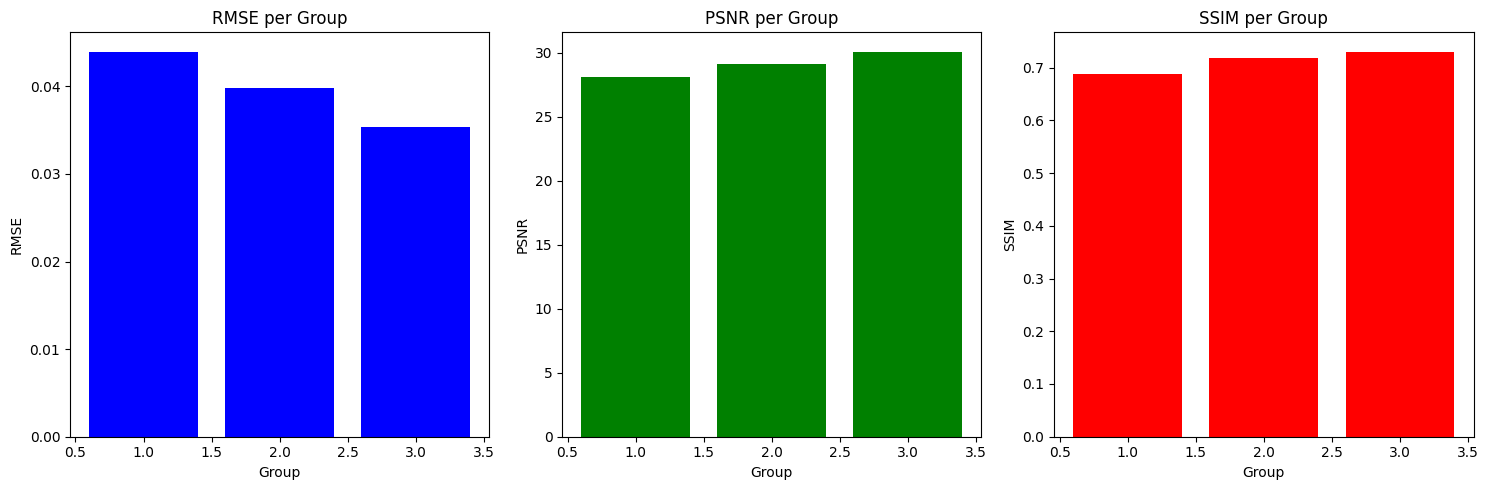

In [234]:
import numpy as np
import matplotlib.pyplot as plt

# 각 지표에 대해 6개씩 그룹화하여 평균값 계산
rmse_groups = [np.mean(rmse_list[0:2]), np.mean(rmse_list[2:4]), np.mean(rmse_list[4:6])]
psnr_groups = [np.mean(psnr_list[0:2]), np.mean(psnr_list[2:4]), np.mean(psnr_list[4:6])]
ssim_groups = [np.mean(ssim_list[0:2]), np.mean(ssim_list[2:4]), np.mean(ssim_list[4:6])]

# 그룹 인덱스 (1, 2, 3)
groups = [1, 2, 3]

# 그래프 그리기
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# RMSE 그래프
axs[0].bar(groups, rmse_groups, color='b')
axs[0].set_title('RMSE per Group')
axs[0].set_xlabel('Group')
axs[0].set_ylabel('RMSE')

# PSNR 그래프
axs[1].bar(groups, psnr_groups, color='g')
axs[1].set_title('PSNR per Group')
axs[1].set_xlabel('Group')
axs[1].set_ylabel('PSNR')

# SSIM 그래프
axs[2].bar(groups, ssim_groups, color='r')
axs[2].set_title('SSIM per Group')
axs[2].set_xlabel('Group')
axs[2].set_ylabel('SSIM')

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

In [235]:
# 평균(mean)과 표준편차(sd) 계산
rmse_mean = np.mean(rmse_list)
rmse_sd = np.std(rmse_list)

psnr_mean = np.mean(psnr_list)
psnr_sd = np.std(psnr_list)

ssim_mean = np.mean(ssim_list)
ssim_sd = np.std(ssim_list)

# 결과를 mean ± sd 형식으로 표현
rmse_result = f"{rmse_mean:.4f} ± {rmse_sd:.4f}"
psnr_result = f"{psnr_mean:.4f} ± {psnr_sd:.4f}"
ssim_result = f"{ssim_mean:.4f} ± {ssim_sd:.4f}"

# 결과 출력
print(f"RMSE: {rmse_result}")
print(f"PSNR: {psnr_result}")
print(f"SSIM: {ssim_result}")

RMSE: 0.0397 ± 0.0040
PSNR: 29.1317 ± 0.9085
SSIM: 0.7119 ± 0.0235


In [236]:
import os
import numpy as np

# 파일 저장 경로
file_names = {
    "loss": "loss_list.npy",
    "psnr": "psnr_list.npy",
    "ssim": "ssim_list.npy"
}

# 각 리스트를 저장
np.save(file_names["loss"], loss_list)
np.save(file_names["psnr"], psnr_list)
np.save(file_names["ssim"], ssim_list)

print(f"Lists have been saved in the 'unet' folder:\n- {file_names['loss']}\n- {file_names['psnr']}\n- {file_names['ssim']}")


Lists have been saved in the 'unet' folder:
- loss_list.npy
- psnr_list.npy
- ssim_list.npy


# 1-2. REDCNN with C.A.

In [237]:
!pwd

/root/code/redcnn/base


In [238]:
%cd /root/code/redcnn/attention_channel/

/root/code/redcnn/attention_channel


In [239]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [240]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
        self.last_attention = None  # 저장된 Attention 값을 위한 변수

    def forward(self, x):
        batch, channels, _, _ = x.size()
        # 채널별 전역 평균 풀링
        y = self.avg_pool(x).view(batch, channels)
        y = self.fc(y).view(batch, channels, 1, 1)
        self.last_attention = y  # 계산된 Attention Weight 저장
        return x * y


In [241]:
class RedCNNWithChannelAttention(nn.Module):
    def __init__(self):
        super(RedCNNWithChannelAttention, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)

        # Attention Blocks (효율적 배치)
        self.attention2 = SEBlock(96)  # 중간 계층
        self.attention3 = SEBlock(96)  # 고수준 특징 계층

        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()

    def forward(self, x):
        # 인코더 부분
        residual1 = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x
        x = self.relu(self.conv3(x))
        x = self.attention2(x)  # 중간 계층에 Attention
        x = self.relu(self.conv4(x))
        residual3 = x
        x = self.relu(self.conv5(x))
        x = self.attention3(x)  # 최종 인코더 계층에 Attention

        # 디코더 부분
        x = self.relu(self.deconv1(x) + residual3)
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x) + residual2)
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1

        return x

In [242]:
import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNNWithChannelAttention().to(device)
model.load_state_dict(torch.load('red_cnn_C_A.pth'))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :]) 
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  17%|█▋        | 1005/6025 [00:20<01:43, 48.59it/s]

RMSE per interval: 0.0453, PSNR per interval: 27.72, SSIM per interval: 0.6789


Evaluating:  33%|███▎      | 2005/6025 [00:40<01:22, 48.66it/s]

RMSE per interval: 0.0427, PSNR per interval: 28.53, SSIM per interval: 0.6947


Evaluating:  50%|████▉     | 3005/6025 [01:01<01:02, 48.69it/s]

RMSE per interval: 0.0430, PSNR per interval: 28.69, SSIM per interval: 0.7037


Evaluating:  66%|██████▋   | 4005/6025 [01:21<00:41, 48.69it/s]

RMSE per interval: 0.0367, PSNR per interval: 29.66, SSIM per interval: 0.7306


Evaluating:  83%|████████▎ | 5005/6025 [01:42<00:20, 48.67it/s]

RMSE per interval: 0.0363, PSNR per interval: 29.79, SSIM per interval: 0.7091


Evaluating: 100%|█████████▉| 6005/6025 [02:02<00:00, 48.67it/s]

RMSE per interval: 0.0343, PSNR per interval: 30.51, SSIM per interval: 0.7513


Evaluating: 100%|██████████| 6025/6025 [02:02<00:00, 49.03it/s]

Average RMSE over all intervals: 0.039718


In [243]:
len(loss_list), len(psnr_list), len(ssim_list)

(6, 6, 6)

In [244]:
rmse_list = loss_list
rmse_list

[0.04529176481999457,
 0.04269160277023912,
 0.04295010657887906,
 0.03672503125481307,
 0.03630090566817671,
 0.03434676932264119]

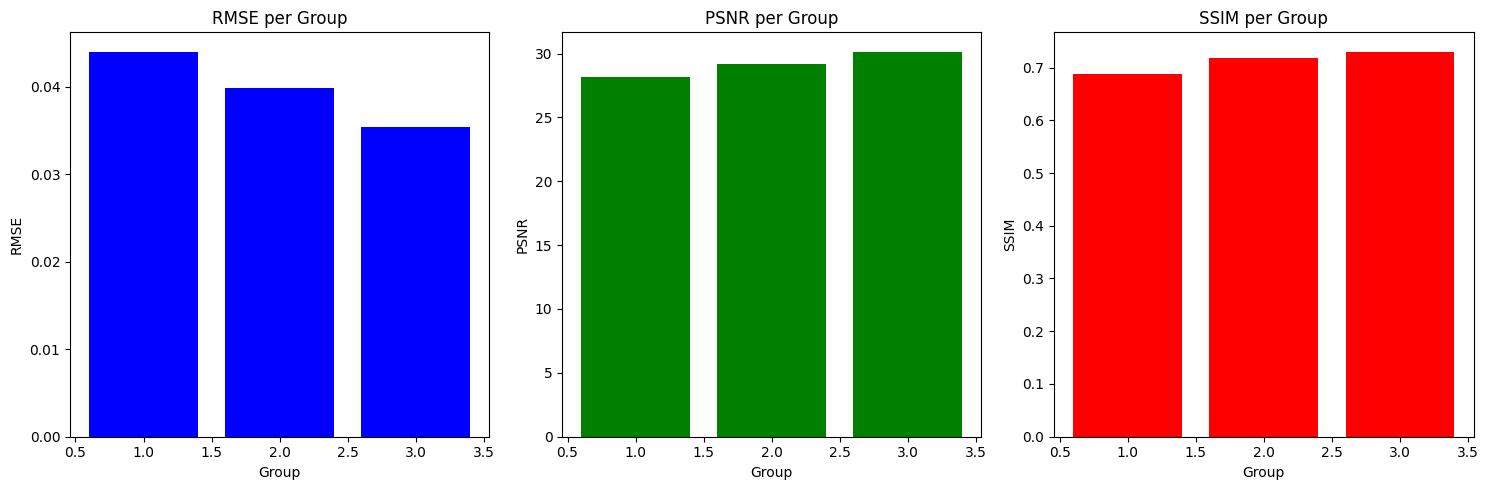

In [245]:
import numpy as np
import matplotlib.pyplot as plt

# 각 지표에 대해 6개씩 그룹화하여 평균값 계산
rmse_groups = [np.mean(rmse_list[0:2]), np.mean(rmse_list[2:4]), np.mean(rmse_list[4:6])]
psnr_groups = [np.mean(psnr_list[0:2]), np.mean(psnr_list[2:4]), np.mean(psnr_list[4:6])]
ssim_groups = [np.mean(ssim_list[0:2]), np.mean(ssim_list[2:4]), np.mean(ssim_list[4:6])]

# 그룹 인덱스 (1, 2, 3)
groups = [1, 2, 3]

# 그래프 그리기
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# RMSE 그래프
axs[0].bar(groups, rmse_groups, color='b')
axs[0].set_title('RMSE per Group')
axs[0].set_xlabel('Group')
axs[0].set_ylabel('RMSE')

# PSNR 그래프
axs[1].bar(groups, psnr_groups, color='g')
axs[1].set_title('PSNR per Group')
axs[1].set_xlabel('Group')
axs[1].set_ylabel('PSNR')

# SSIM 그래프
axs[2].bar(groups, ssim_groups, color='r')
axs[2].set_title('SSIM per Group')
axs[2].set_xlabel('Group')
axs[2].set_ylabel('SSIM')

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

In [246]:
# 평균(mean)과 표준편차(sd) 계산
rmse_mean = np.mean(rmse_list)
rmse_sd = np.std(rmse_list)

psnr_mean = np.mean(psnr_list)
psnr_sd = np.std(psnr_list)

ssim_mean = np.mean(ssim_list)
ssim_sd = np.std(ssim_list)

# 결과를 mean ± sd 형식으로 표현
rmse_result = f"{rmse_mean:.4f} ± {rmse_sd:.4f}"
psnr_result = f"{psnr_mean:.4f} ± {psnr_sd:.4f}"
ssim_result = f"{ssim_mean:.4f} ± {ssim_sd:.4f}"

# 결과 출력
print(f"RMSE: {rmse_result}")
print(f"PSNR: {psnr_result}")
print(f"SSIM: {ssim_result}")

RMSE: 0.0397 ± 0.0041
PSNR: 29.1518 ± 0.9279
SSIM: 0.7114 ± 0.0237


In [247]:
import os
import numpy as np

# 파일 저장 경로
file_names = {
    "loss": "loss_list.npy",
    "psnr": "psnr_list.npy",
    "ssim": "ssim_list.npy"
}

# 각 리스트를 저장
np.save(file_names["loss"], loss_list)
np.save(file_names["psnr"], psnr_list)
np.save(file_names["ssim"], ssim_list)

print(f"Lists have been saved in the 'unet' folder:\n- {file_names['loss']}\n- {file_names['psnr']}\n- {file_names['ssim']}")


Lists have been saved in the 'unet' folder:
- loss_list.npy
- psnr_list.npy
- ssim_list.npy


# 1-3. REDCNN with S.A.

In [248]:
!pwd

/root/code/redcnn/attention_channel


In [249]:
%cd /root/code/redcnn/attention_spatial/

/root/code/redcnn/attention_spatial


In [250]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [251]:
import torch
import torch.nn as nn

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "Kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2 # 동일한 크기를 유지하기 위한 패딩
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.last_attention = None  # Attention 값을 저장하는 변수

    def forward(self, x):
        # 채널 차원을 압축 (Max Pooling과 Average Pooling)
        avg_out = torch.mean(x, dim=1, keepdim=True) # Average pooling
        max_out, _ = torch.max(x, dim=1, keepdim=True) # Max pooling
        combined = torch.cat([avg_out, max_out], dim=1) # 채널 차원에서 결합
        # 2D Convolution 적용
        attention = self.sigmoid(self.conv(combined)) # [B, 1, H, W]
        self.last_attention = attention  # Attention 값을 저장
        return x * attention

In [252]:
class RedCNNWithSpatialAttention(nn.Module):
    def __init__(self):
        super(RedCNNWithSpatialAttention, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)

        # Spatial Attention Blocks
        self.spatial_attention3 = SpatialAttention()
        self.spatial_attention5 = SpatialAttention()

        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()

    def forward(self, x):
        # 인코더 부분
        residual1 = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x
        x = self.relu(self.conv3(x))
        x = self.spatial_attention3(x)  # Spatial Attention (3번째 위치)
        x = self.relu(self.conv4(x))
        residual3 = x
        x = self.relu(self.conv5(x))
        x = self.spatial_attention5(x)  # Spatial Attention (5번째 위치)

        # 디코더 부분
        x = self.relu(self.deconv1(x) + residual3)
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x) + residual2)
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1

        return x

In [253]:
import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNNWithSpatialAttention().to(device)
model.load_state_dict(torch.load('red_cnn_S_A.pth'))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :]) 
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  17%|█▋        | 1005/6025 [00:20<01:44, 48.25it/s]

RMSE per interval: 0.0453, PSNR per interval: 27.71, SSIM per interval: 0.6801


Evaluating:  33%|███▎      | 2005/6025 [00:41<01:23, 48.15it/s]

RMSE per interval: 0.0427, PSNR per interval: 28.50, SSIM per interval: 0.6960


Evaluating:  50%|████▉     | 3005/6025 [01:01<01:02, 48.24it/s]

RMSE per interval: 0.0430, PSNR per interval: 28.66, SSIM per interval: 0.7050


Evaluating:  66%|██████▋   | 4005/6025 [01:22<00:41, 48.30it/s]

RMSE per interval: 0.0369, PSNR per interval: 29.63, SSIM per interval: 0.7305


Evaluating:  83%|████████▎ | 5005/6025 [01:42<00:21, 48.29it/s]

RMSE per interval: 0.0365, PSNR per interval: 29.73, SSIM per interval: 0.7089


Evaluating: 100%|█████████▉| 6005/6025 [02:03<00:00, 48.30it/s]

RMSE per interval: 0.0344, PSNR per interval: 30.47, SSIM per interval: 0.7518


Evaluating: 100%|██████████| 6025/6025 [02:03<00:00, 48.64it/s]

Average RMSE over all intervals: 0.039808


In [254]:
len(loss_list), len(psnr_list), len(ssim_list)

(6, 6, 6)

In [255]:
rmse_list = loss_list
rmse_list

[0.045342756735160944,
 0.042749563889577985,
 0.043015779936686156,
 0.036852610416710375,
 0.03648667409364134,
 0.034399629756808284]

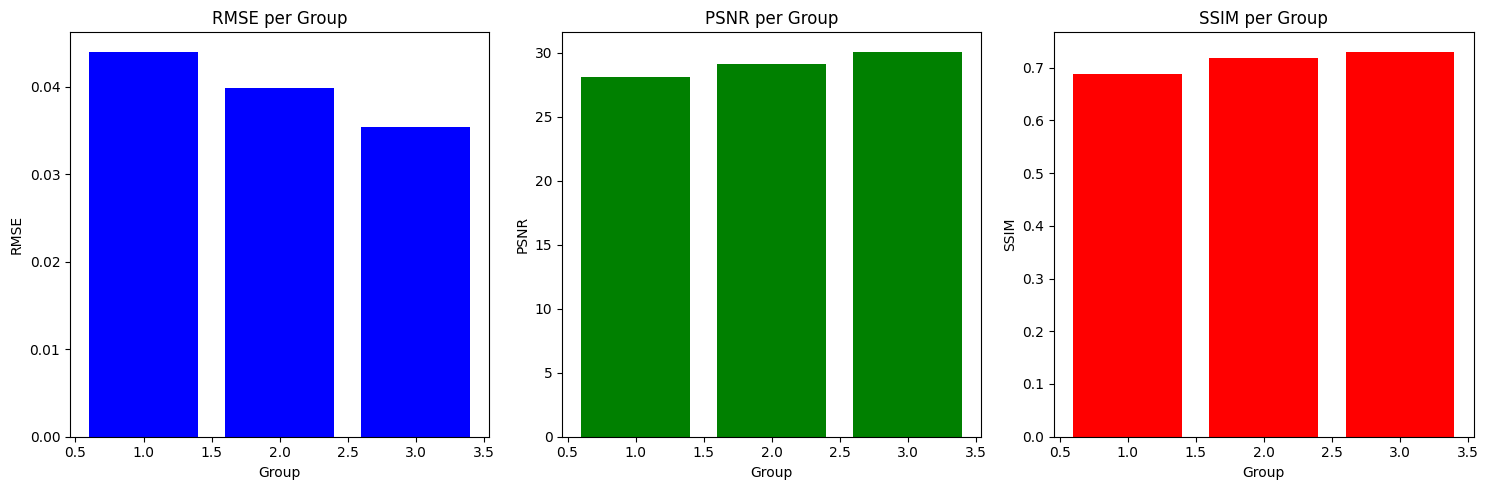

In [256]:
import numpy as np
import matplotlib.pyplot as plt

# 각 지표에 대해 6개씩 그룹화하여 평균값 계산
rmse_groups = [np.mean(rmse_list[0:2]), np.mean(rmse_list[2:4]), np.mean(rmse_list[4:6])]
psnr_groups = [np.mean(psnr_list[0:2]), np.mean(psnr_list[2:4]), np.mean(psnr_list[4:6])]
ssim_groups = [np.mean(ssim_list[0:2]), np.mean(ssim_list[2:4]), np.mean(ssim_list[4:6])]

# 그룹 인덱스 (1, 2, 3)
groups = [1, 2, 3]

# 그래프 그리기
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# RMSE 그래프
axs[0].bar(groups, rmse_groups, color='b')
axs[0].set_title('RMSE per Group')
axs[0].set_xlabel('Group')
axs[0].set_ylabel('RMSE')

# PSNR 그래프
axs[1].bar(groups, psnr_groups, color='g')
axs[1].set_title('PSNR per Group')
axs[1].set_xlabel('Group')
axs[1].set_ylabel('PSNR')

# SSIM 그래프
axs[2].bar(groups, ssim_groups, color='r')
axs[2].set_title('SSIM per Group')
axs[2].set_xlabel('Group')
axs[2].set_ylabel('SSIM')

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

In [257]:
# 평균(mean)과 표준편차(sd) 계산
rmse_mean = np.mean(rmse_list)
rmse_sd = np.std(rmse_list)

psnr_mean = np.mean(psnr_list)
psnr_sd = np.std(psnr_list)

ssim_mean = np.mean(ssim_list)
ssim_sd = np.std(ssim_list)

# 결과를 mean ± sd 형식으로 표현
rmse_result = f"{rmse_mean:.4f} ± {rmse_sd:.4f}"
psnr_result = f"{psnr_mean:.4f} ± {psnr_sd:.4f}"
ssim_result = f"{ssim_mean:.4f} ± {ssim_sd:.4f}"

# 결과 출력
print(f"RMSE: {rmse_result}")
print(f"PSNR: {psnr_result}")
print(f"SSIM: {ssim_result}")

RMSE: 0.0398 ± 0.0041
PSNR: 29.1163 ± 0.9152
SSIM: 0.7121 ± 0.0233


In [258]:
import os
import numpy as np

# 파일 저장 경로
file_names = {
    "loss": "loss_list.npy",
    "psnr": "psnr_list.npy",
    "ssim": "ssim_list.npy"
}

# 각 리스트를 저장
np.save(file_names["loss"], loss_list)
np.save(file_names["psnr"], psnr_list)
np.save(file_names["ssim"], ssim_list)

print(f"Lists have been saved in the 'unet' folder:\n- {file_names['loss']}\n- {file_names['psnr']}\n- {file_names['ssim']}")


Lists have been saved in the 'unet' folder:
- loss_list.npy
- psnr_list.npy
- ssim_list.npy


# 2. UNet

In [259]:
!pwd

/root/code/redcnn/attention_spatial


In [260]:
%cd /root/code/unet/base

/root/code/unet/base


In [261]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [262]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        # 1. encoder 부분
        self.encoder = nn.ModuleList()
        # 2. decoder 부분
        self.decoder = nn.ModuleList()
        
        # Encoder: Down-sampling path
        for feature in features:
            self.encoder.append(self.conv_block(in_channels, feature)) # (1,64),(64,128),...,(256,512)
            in_channels = feature
        
        # Bottleneck
        self.bottleneck = self.conv_block(features[-1], features[-1] * 2) # ConvTranspose2d
        
        # Decoder: Up-sampling path
        for feature in reversed(features): # (512,256),...,(128,64)
            # encoder에서는 max_pool을 했지만, decoder에서는 max,mean도 아닌 그냥 conv를 이용해 사이즈를 pool의 반대로 만든다.
            self.decoder.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(self.conv_block(feature * 2, feature))
        
        # Final Convolution to match output channels
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1) # 64->1, 1x1-Conv

    def forward(self, x):
        enc_outputs = []
        
        # Encoder path
        for layer in self.encoder:
            x = layer(x)
            enc_outputs.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2) # feature map 사이즈를 절반으로 줄인다.
        
        # Bottleneck
        x = self.bottleneck(x) # 512 -> 1024
        
        # Decoder path
        for idx in range(0, len(self.decoder), 2): # 0,2,4 <- max-pool의 결과가 아닌 conv의 결과만 가져오기위해
            x = self.decoder[idx](x)  # Upsample
            enc_output = enc_outputs[-(idx // 2) - 1]  # Skip connection; -1,-2,-3
            x = F.interpolate(x, size=enc_output.shape[2:], mode='bilinear', align_corners=False) # encoder와 사이즈를 동일하게 맞춘다.
            # input 사이즈가 2의 제곱수가 아니기 때문에 넣어주어야한다.
            x = torch.cat((enc_output, x), dim=1)  # Concatenate encoder output
            x = self.decoder[idx + 1](x)  # Convolution after concatenation
        
        return self.final_conv(x)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), # feature map 사이즈 유지
            # nn.BatchNorm2d(out_channels),  # Add normalization for stability
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            # nn.BatchNorm2d(out_channels),  # Add normalization for stability
            nn.ReLU(inplace=True)
        )

In [263]:
import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('unet.pth'))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :]) 
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  17%|█▋        | 1005/6025 [00:20<01:44, 48.00it/s]

RMSE per interval: 0.0462, PSNR per interval: 27.54, SSIM per interval: 0.6764


Evaluating:  33%|███▎      | 2005/6025 [00:41<01:23, 47.94it/s]

RMSE per interval: 0.0434, PSNR per interval: 28.33, SSIM per interval: 0.6921


Evaluating:  50%|████▉     | 3005/6025 [01:02<01:03, 47.88it/s]

RMSE per interval: 0.0440, PSNR per interval: 28.39, SSIM per interval: 0.7006


Evaluating:  66%|██████▋   | 4005/6025 [01:22<00:42, 47.98it/s]

RMSE per interval: 0.0377, PSNR per interval: 29.38, SSIM per interval: 0.7263


Evaluating:  83%|████████▎ | 5005/6025 [01:43<00:21, 47.96it/s]

RMSE per interval: 0.0372, PSNR per interval: 29.52, SSIM per interval: 0.7056


Evaluating: 100%|█████████▉| 6005/6025 [02:04<00:00, 47.94it/s]

RMSE per interval: 0.0350, PSNR per interval: 30.26, SSIM per interval: 0.7486


Evaluating: 100%|██████████| 6025/6025 [02:04<00:00, 48.34it/s]

Average RMSE over all intervals: 0.040575


In [264]:
len(loss_list), len(psnr_list), len(ssim_list)

(6, 6, 6)

In [265]:
rmse_list = loss_list
rmse_list

[0.0461745982542634,
 0.043381837336346506,
 0.04399286542739719,
 0.0377488510273397,
 0.03718932415451855,
 0.034965296996757385]

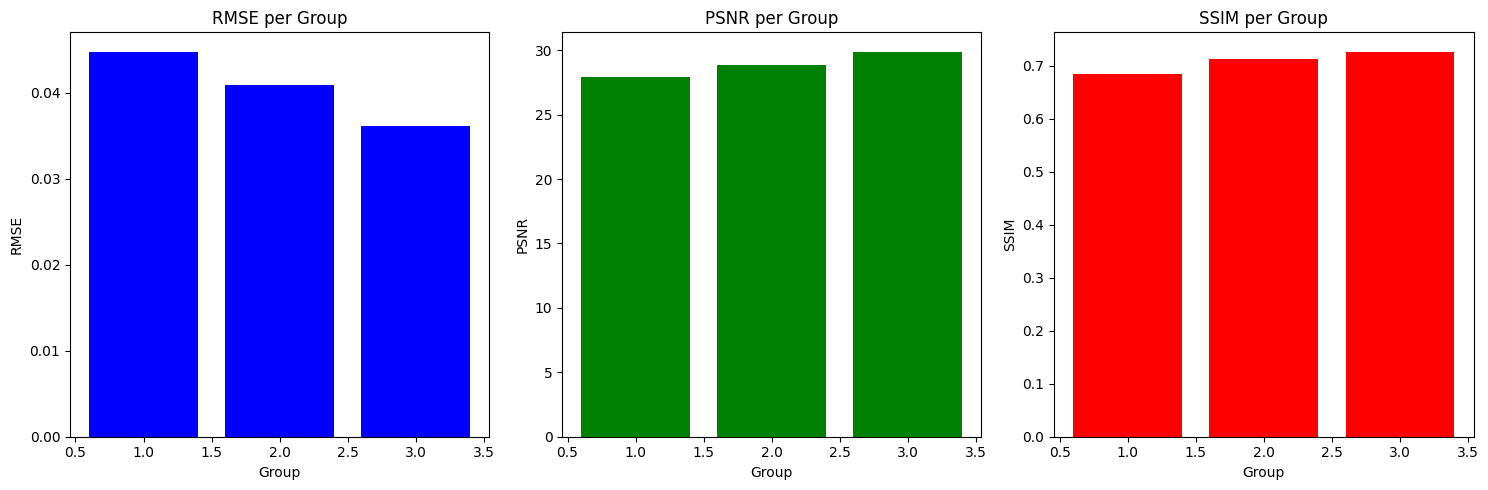

In [266]:
import numpy as np
import matplotlib.pyplot as plt

# 각 지표에 대해 6개씩 그룹화하여 평균값 계산
rmse_groups = [np.mean(rmse_list[0:2]), np.mean(rmse_list[2:4]), np.mean(rmse_list[4:6])]
psnr_groups = [np.mean(psnr_list[0:2]), np.mean(psnr_list[2:4]), np.mean(psnr_list[4:6])]
ssim_groups = [np.mean(ssim_list[0:2]), np.mean(ssim_list[2:4]), np.mean(ssim_list[4:6])]

# 그룹 인덱스 (1, 2, 3)
groups = [1, 2, 3]

# 그래프 그리기
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# RMSE 그래프
axs[0].bar(groups, rmse_groups, color='b')
axs[0].set_title('RMSE per Group')
axs[0].set_xlabel('Group')
axs[0].set_ylabel('RMSE')

# PSNR 그래프
axs[1].bar(groups, psnr_groups, color='g')
axs[1].set_title('PSNR per Group')
axs[1].set_xlabel('Group')
axs[1].set_ylabel('PSNR')

# SSIM 그래프
axs[2].bar(groups, ssim_groups, color='r')
axs[2].set_title('SSIM per Group')
axs[2].set_xlabel('Group')
axs[2].set_ylabel('SSIM')

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

In [267]:
# 평균(mean)과 표준편차(sd) 계산
rmse_mean = np.mean(rmse_list)
rmse_sd = np.std(rmse_list)

psnr_mean = np.mean(psnr_list)
psnr_sd = np.std(psnr_list)

ssim_mean = np.mean(ssim_list)
ssim_sd = np.std(ssim_list)

# 결과를 mean ± sd 형식으로 표현
rmse_result = f"{rmse_mean:.4f} ± {rmse_sd:.4f}"
psnr_result = f"{psnr_mean:.4f} ± {psnr_sd:.4f}"
ssim_result = f"{ssim_mean:.4f} ± {ssim_sd:.4f}"

# 결과 출력
print(f"RMSE: {rmse_result}")
print(f"PSNR: {psnr_result}")
print(f"SSIM: {ssim_result}")

RMSE: 0.0406 ± 0.0041
PSNR: 28.9032 ± 0.9015
SSIM: 0.7083 ± 0.0234


In [268]:
import os
import numpy as np

# 파일 저장 경로
file_names = {
    "loss": "loss_list.npy",
    "psnr": "psnr_list.npy",
    "ssim": "ssim_list.npy"
}

# 각 리스트를 저장
np.save(file_names["loss"], loss_list)
np.save(file_names["psnr"], psnr_list)
np.save(file_names["ssim"], ssim_list)

print(f"Lists have been saved in the 'unet' folder:\n- {file_names['loss']}\n- {file_names['psnr']}\n- {file_names['ssim']}")


Lists have been saved in the 'unet' folder:
- loss_list.npy
- psnr_list.npy
- ssim_list.npy


# 2-2. UNet with C.A.

In [269]:
!pwd

/root/code/unet/base


In [270]:
%cd /root/code/unet/attention_channel/

/root/code/unet/attention_channel


In [271]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [272]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
        self.last_attention = None  # 저장된 Attention 값을 위한 변수

    def forward(self, x):
        batch, channels, _, _ = x.size()
        # 채널별 전역 평균 풀링
        y = self.avg_pool(x).view(batch, channels)
        y = self.fc(y).view(batch, channels, 1, 1)
        self.last_attention = y  # 계산된 Attention Weight 저장
        return x * y


In [273]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# UNet with Selective Channel Attention
class UNetWithChannelAttention(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512], reduction=16):
        super(UNetWithChannelAttention, self).__init__()

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.attention_blocks = nn.ModuleList()

        # Encoder Path
        for idx, feature in enumerate(features):
            self.encoder.append(self.conv_block(in_channels, feature))
            if idx in [1, 3]:  # Attention 적용 위치
                self.attention_blocks.append(SEBlock(feature, reduction=reduction))
            else:
                self.attention_blocks.append(nn.Identity())  # Placeholder로 nn.Identity 사용
            in_channels = feature

        # Bottleneck
        self.bottleneck = self.conv_block(features[-1], features[-1] * 2)

        # Decoder Path
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(self.conv_block(feature * 2, feature))

        # Final Convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        enc_outputs = []

        # Encoder Path
        for idx, layer in enumerate(self.encoder):
            x = layer(x)
            x = self.attention_blocks[idx](x)  # Attention 적용
            enc_outputs.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder Path
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)  # Upsample
            enc_output = enc_outputs[-(idx // 2) - 1]  # Skip connection
            x = F.interpolate(x, size=enc_output.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat((enc_output, x), dim=1)  # Concatenate
            x = self.decoder[idx + 1](x)  # Convolution after concatenation

        return self.final_conv(x)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )


In [274]:
import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNetWithChannelAttention().to(device)
model.load_state_dict(torch.load('unet_C_A.pth'))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :]) 
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  17%|█▋        | 1005/6025 [00:21<01:49, 45.82it/s]

RMSE per interval: 0.0468, PSNR per interval: 27.39, SSIM per interval: 0.6736


Evaluating:  33%|███▎      | 2005/6025 [00:43<01:27, 45.79it/s]

RMSE per interval: 0.0447, PSNR per interval: 28.01, SSIM per interval: 0.6911


Evaluating:  50%|████▉     | 3005/6025 [01:05<01:05, 45.80it/s]

RMSE per interval: 0.0450, PSNR per interval: 28.07, SSIM per interval: 0.7002


Evaluating:  66%|██████▋   | 4005/6025 [01:26<00:44, 45.79it/s]

RMSE per interval: 0.0392, PSNR per interval: 28.98, SSIM per interval: 0.7252


Evaluating:  83%|████████▎ | 5005/6025 [01:48<00:22, 45.83it/s]

RMSE per interval: 0.0388, PSNR per interval: 29.09, SSIM per interval: 0.7037


Evaluating: 100%|█████████▉| 6005/6025 [02:10<00:00, 45.19it/s]

RMSE per interval: 0.0363, PSNR per interval: 29.85, SSIM per interval: 0.7461


Evaluating: 100%|██████████| 6025/6025 [02:10<00:00, 46.13it/s]

Average RMSE over all intervals: 0.041804


In [275]:
len(loss_list), len(psnr_list), len(ssim_list)

(6, 6, 6)

In [276]:
rmse_list = loss_list

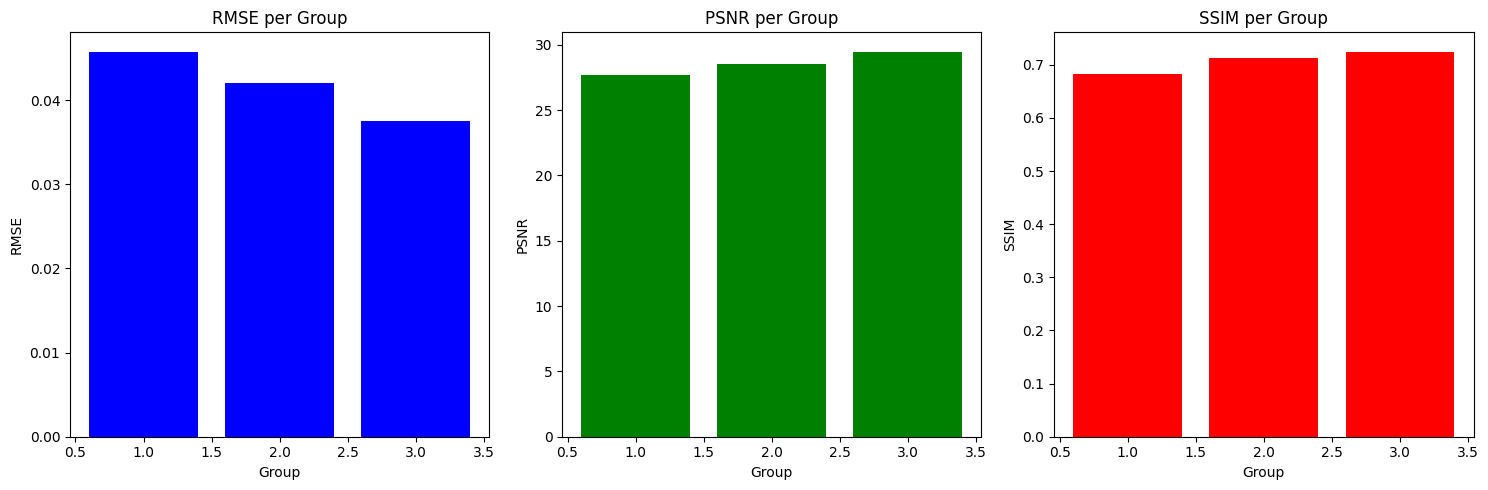

In [277]:
import numpy as np
import matplotlib.pyplot as plt

# 각 지표에 대해 6개씩 그룹화하여 평균값 계산
rmse_groups = [np.mean(rmse_list[0:2]), np.mean(rmse_list[2:4]), np.mean(rmse_list[4:6])]
psnr_groups = [np.mean(psnr_list[0:2]), np.mean(psnr_list[2:4]), np.mean(psnr_list[4:6])]
ssim_groups = [np.mean(ssim_list[0:2]), np.mean(ssim_list[2:4]), np.mean(ssim_list[4:6])]

# 그룹 인덱스 (1, 2, 3)
groups = [1, 2, 3]

# 그래프 그리기
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# RMSE 그래프
axs[0].bar(groups, rmse_groups, color='b')
axs[0].set_title('RMSE per Group')
axs[0].set_xlabel('Group')
axs[0].set_ylabel('RMSE')

# PSNR 그래프
axs[1].bar(groups, psnr_groups, color='g')
axs[1].set_title('PSNR per Group')
axs[1].set_xlabel('Group')
axs[1].set_ylabel('PSNR')

# SSIM 그래프
axs[2].bar(groups, ssim_groups, color='r')
axs[2].set_title('SSIM per Group')
axs[2].set_xlabel('Group')
axs[2].set_ylabel('SSIM')

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

In [278]:
# 평균(mean)과 표준편차(sd) 계산
rmse_mean = np.mean(rmse_list)
rmse_sd = np.std(rmse_list)

psnr_mean = np.mean(psnr_list)
psnr_sd = np.std(psnr_list)

ssim_mean = np.mean(ssim_list)
ssim_sd = np.std(ssim_list)

# 결과를 mean ± sd 형식으로 표현
rmse_result = f"{rmse_mean:.4f} ± {rmse_sd:.4f}"
psnr_result = f"{psnr_mean:.4f} ± {psnr_sd:.4f}"
ssim_result = f"{ssim_mean:.4f} ± {ssim_sd:.4f}"

# 결과 출력
print(f"RMSE: {rmse_result}")
print(f"PSNR: {psnr_result}")
print(f"SSIM: {ssim_result}")

RMSE: 0.0418 ± 0.0039
PSNR: 28.5650 ± 0.8190
SSIM: 0.7066 ± 0.0234


In [279]:
import os
import numpy as np

# 파일 저장 경로
file_names = {
    "loss": "loss_list.npy",
    "psnr": "psnr_list.npy",
    "ssim": "ssim_list.npy"
}

# 각 리스트를 저장
np.save(file_names["loss"], loss_list)
np.save(file_names["psnr"], psnr_list)
np.save(file_names["ssim"], ssim_list)

print(f"Lists have been saved in the 'unet' folder:\n- {file_names['loss']}\n- {file_names['psnr']}\n- {file_names['ssim']}")


Lists have been saved in the 'unet' folder:
- loss_list.npy
- psnr_list.npy
- ssim_list.npy


# 2-3. UNet with S.A.

In [280]:
!pwd

/root/code/unet/attention_channel


In [281]:
%cd /root/code/unet/attention_spatial/

/root/code/unet/attention_spatial


In [282]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [283]:
import torch
import torch.nn as nn

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "Kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2 # 동일한 크기를 유지하기 위한 패딩
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.last_attention = None  # Attention 값을 저장하는 변수

    def forward(self, x):
        # 채널 차원을 압축 (Max Pooling과 Average Pooling)
        avg_out = torch.mean(x, dim=1, keepdim=True) # Average pooling
        max_out, _ = torch.max(x, dim=1, keepdim=True) # Max pooling
        combined = torch.cat([avg_out, max_out], dim=1) # 채널 차원에서 결합
        # 2D Convolution 적용
        attention = self.sigmoid(self.conv(combined)) # [B, 1, H, W]
        self.last_attention = attention  # Attention 값을 저장
        return x * attention

In [284]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# UNet with Selective Channel Attention
class UNetWithSpatialAttention(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512], reduction=16):
        super(UNetWithSpatialAttention, self).__init__()

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.attention_blocks = nn.ModuleList()

        # Encoder Path
        for idx, feature in enumerate(features):
            self.encoder.append(self.conv_block(in_channels, feature))
            if idx in [1, 3]:  # Attention 적용 위치
                self.attention_blocks.append(SpatialAttention())
            else:
                self.attention_blocks.append(nn.Identity())  # Placeholder로 nn.Identity 사용
            in_channels = feature

        # Bottleneck
        self.bottleneck = self.conv_block(features[-1], features[-1] * 2)

        # Decoder Path
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(self.conv_block(feature * 2, feature))

        # Final Convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        enc_outputs = []

        # Encoder Path
        for idx, layer in enumerate(self.encoder):
            x = layer(x)
            x = self.attention_blocks[idx](x)  # Attention 적용
            enc_outputs.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder Path
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)  # Upsample
            enc_output = enc_outputs[-(idx // 2) - 1]  # Skip connection
            x = F.interpolate(x, size=enc_output.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat((enc_output, x), dim=1)  # Concatenate
            x = self.decoder[idx + 1](x)  # Convolution after concatenation

        return self.final_conv(x)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )


In [285]:
import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNetWithSpatialAttention().to(device)
model.load_state_dict(torch.load('unet_S_A.pth'))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :]) 
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  17%|█▋        | 1005/6025 [00:21<01:49, 45.65it/s]

RMSE per interval: 0.0480, PSNR per interval: 27.14, SSIM per interval: 0.6699


Evaluating:  33%|███▎      | 2005/6025 [00:43<01:28, 45.58it/s]

RMSE per interval: 0.0456, PSNR per interval: 27.77, SSIM per interval: 0.6843


Evaluating:  50%|████▉     | 3005/6025 [01:05<01:06, 45.65it/s]

RMSE per interval: 0.0460, PSNR per interval: 27.85, SSIM per interval: 0.6938


Evaluating:  66%|██████▋   | 4005/6025 [01:27<00:44, 45.66it/s]

RMSE per interval: 0.0399, PSNR per interval: 28.74, SSIM per interval: 0.7172


Evaluating:  83%|████████▎ | 5005/6025 [01:48<00:22, 45.59it/s]

RMSE per interval: 0.0397, PSNR per interval: 28.84, SSIM per interval: 0.6959


Evaluating: 100%|█████████▉| 6005/6025 [02:10<00:00, 45.59it/s]

RMSE per interval: 0.0378, PSNR per interval: 29.47, SSIM per interval: 0.7392


Evaluating: 100%|██████████| 6025/6025 [02:11<00:00, 45.95it/s]

Average RMSE over all intervals: 0.042816


In [286]:
len(loss_list), len(psnr_list), len(ssim_list)

(6, 6, 6)

In [287]:
rmse_list = loss_list
rmse_list

[0.04799015559069812,
 0.04561671837233007,
 0.045962102169170974,
 0.03989830264449119,
 0.03966915669292211,
 0.03775961230508983]

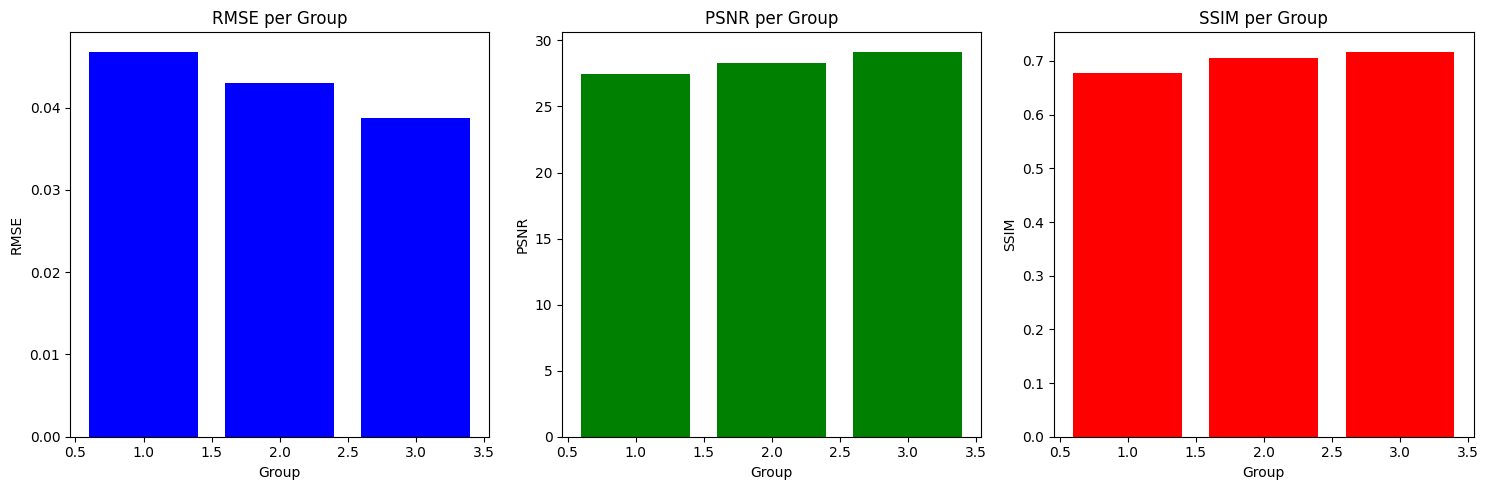

In [288]:
import numpy as np
import matplotlib.pyplot as plt

# 각 지표에 대해 6개씩 그룹화하여 평균값 계산
rmse_groups = [np.mean(rmse_list[0:2]), np.mean(rmse_list[2:4]), np.mean(rmse_list[4:6])]
psnr_groups = [np.mean(psnr_list[0:2]), np.mean(psnr_list[2:4]), np.mean(psnr_list[4:6])]
ssim_groups = [np.mean(ssim_list[0:2]), np.mean(ssim_list[2:4]), np.mean(ssim_list[4:6])]

# 그룹 인덱스 (1, 2, 3)
groups = [1, 2, 3]

# 그래프 그리기
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# RMSE 그래프
axs[0].bar(groups, rmse_groups, color='b')
axs[0].set_title('RMSE per Group')
axs[0].set_xlabel('Group')
axs[0].set_ylabel('RMSE')

# PSNR 그래프
axs[1].bar(groups, psnr_groups, color='g')
axs[1].set_title('PSNR per Group')
axs[1].set_xlabel('Group')
axs[1].set_ylabel('PSNR')

# SSIM 그래프
axs[2].bar(groups, ssim_groups, color='r')
axs[2].set_title('SSIM per Group')
axs[2].set_xlabel('Group')
axs[2].set_ylabel('SSIM')

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

In [289]:
# 평균(mean)과 표준편차(sd) 계산
rmse_mean = np.mean(rmse_list)
rmse_sd = np.std(rmse_list)

psnr_mean = np.mean(psnr_list)
psnr_sd = np.std(psnr_list)

ssim_mean = np.mean(ssim_list)
ssim_sd = np.std(ssim_list)

# 결과를 mean ± sd 형식으로 표현
rmse_result = f"{rmse_mean:.4f} ± {rmse_sd:.4f}"
psnr_result = f"{psnr_mean:.4f} ± {psnr_sd:.4f}"
ssim_result = f"{ssim_mean:.4f} ± {ssim_sd:.4f}"

# 결과 출력
print(f"RMSE: {rmse_result}")
print(f"PSNR: {psnr_result}")
print(f"SSIM: {ssim_result}")

RMSE: 0.0428 ± 0.0038
PSNR: 28.3022 ± 0.7832
SSIM: 0.7000 ± 0.0225


In [290]:
import os
import numpy as np

# 파일 저장 경로
file_names = {
    "loss": "loss_list.npy",
    "psnr": "psnr_list.npy",
    "ssim": "ssim_list.npy"
}

# 각 리스트를 저장
np.save(file_names["loss"], loss_list)
np.save(file_names["psnr"], psnr_list)
np.save(file_names["ssim"], ssim_list)

print(f"Lists have been saved in the 'unet' folder:\n- {file_names['loss']}\n- {file_names['psnr']}\n- {file_names['ssim']}")


Lists have been saved in the 'unet' folder:
- loss_list.npy
- psnr_list.npy
- ssim_list.npy


# 최종결과비교

In [291]:
import numpy as np
import matplotlib.pyplot as plt

# 파일 경로 및 데이터 로드
file_names = {
    "loss": "loss_list.npy",
    "psnr": "psnr_list.npy",
    "ssim": "ssim_list.npy"
}

## redcnn 안에서 비교

In [292]:
output_dir = "/root/code/redcnn/base/"
redcnn_rmse_list = np.load(output_dir + file_names["loss"])
redcnn_psnr_list = np.load(output_dir + file_names["psnr"])
redcnn_ssim_list = np.load(output_dir + file_names["ssim"])

output_dir = "/root/code/redcnn/attention_channel/"
redcnnCA_rmse_list = np.load(output_dir + file_names["loss"])
redcnnCA_psnr_list = np.load(output_dir + file_names["psnr"])
redcnnCA_ssim_list = np.load(output_dir + file_names["ssim"])

output_dir = "/root/code/redcnn/attention_spatial/"
redcnnSA_rmse_list = np.load(output_dir + file_names["loss"])
redcnnSA_psnr_list = np.load(output_dir + file_names["psnr"])
redcnnSA_ssim_list = np.load(output_dir + file_names["ssim"])

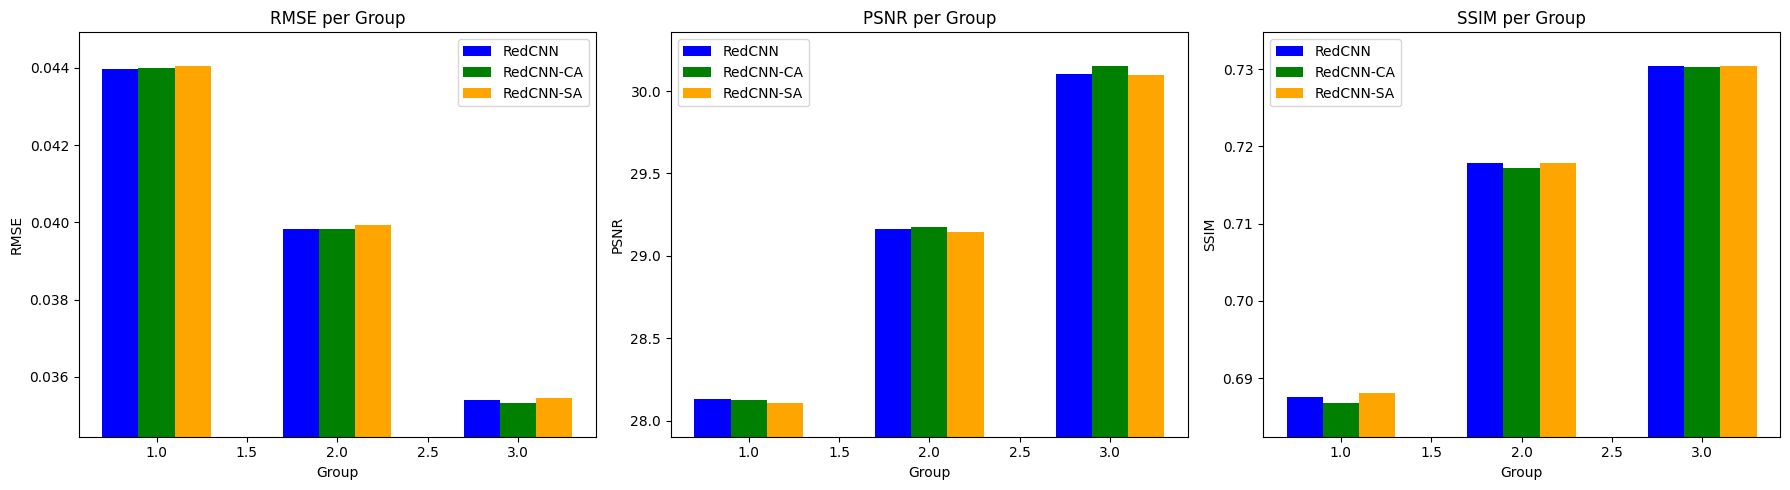

In [293]:
import numpy as np
import matplotlib.pyplot as plt

# RedCNN, RedCNN-CA, RedCNN-SA 결과 그룹화
redcnn_rmse_groups = [np.mean(redcnn_rmse_list[0:2]), np.mean(redcnn_rmse_list[2:4]), np.mean(redcnn_rmse_list[4:6])]
redcnn_psnr_groups = [np.mean(redcnn_psnr_list[0:2]), np.mean(redcnn_psnr_list[2:4]), np.mean(redcnn_psnr_list[4:6])]
redcnn_ssim_groups = [np.mean(redcnn_ssim_list[0:2]), np.mean(redcnn_ssim_list[2:4]), np.mean(redcnn_ssim_list[4:6])]

redcnnCA_rmse_groups = [np.mean(redcnnCA_rmse_list[0:2]), np.mean(redcnnCA_rmse_list[2:4]), np.mean(redcnnCA_rmse_list[4:6])]
redcnnCA_psnr_groups = [np.mean(redcnnCA_psnr_list[0:2]), np.mean(redcnnCA_psnr_list[2:4]), np.mean(redcnnCA_psnr_list[4:6])]
redcnnCA_ssim_groups = [np.mean(redcnnCA_ssim_list[0:2]), np.mean(redcnnCA_ssim_list[2:4]), np.mean(redcnnCA_ssim_list[4:6])]

redcnnSA_rmse_groups = [np.mean(redcnnSA_rmse_list[0:2]), np.mean(redcnnSA_rmse_list[2:4]), np.mean(redcnnSA_rmse_list[4:6])]
redcnnSA_psnr_groups = [np.mean(redcnnSA_psnr_list[0:2]), np.mean(redcnnSA_psnr_list[2:4]), np.mean(redcnnSA_psnr_list[4:6])]
redcnnSA_ssim_groups = [np.mean(redcnnSA_ssim_list[0:2]), np.mean(redcnnSA_ssim_list[2:4]), np.mean(redcnnSA_ssim_list[4:6])]

# 그룹 인덱스 (1, 2, 3)
groups = np.array([1, 2, 3])
bar_width = 0.2  # 막대 너비
offset = bar_width

# y축 범위 설정
def get_y_limits(data_groups):
    all_values = np.concatenate(data_groups)
    min_val = np.min(all_values)
    max_val = np.max(all_values)
    margin = (max_val - min_val) * 0.1  # 여백 추가
    return min_val - margin, max_val + margin

rmse_ymin, rmse_ymax = get_y_limits([redcnn_rmse_groups, redcnnCA_rmse_groups, redcnnSA_rmse_groups])
psnr_ymin, psnr_ymax = get_y_limits([redcnn_psnr_groups, redcnnCA_psnr_groups, redcnnSA_psnr_groups])
ssim_ymin, ssim_ymax = get_y_limits([redcnn_ssim_groups, redcnnCA_ssim_groups, redcnnSA_ssim_groups])

# 그래프 그리기
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# RMSE 그래프
axs[0].bar(groups - offset, redcnn_rmse_groups, bar_width, label='RedCNN', color='b')
axs[0].bar(groups, redcnnCA_rmse_groups, bar_width, label='RedCNN-CA', color='g')
axs[0].bar(groups + offset, redcnnSA_rmse_groups, bar_width, label='RedCNN-SA', color='orange')
axs[0].set_title('RMSE per Group')
axs[0].set_xlabel('Group')
axs[0].set_ylabel('RMSE')
axs[0].set_ylim(rmse_ymin, rmse_ymax)  # y축 범위 설정
axs[0].legend()

# PSNR 그래프
axs[1].bar(groups - offset, redcnn_psnr_groups, bar_width, label='RedCNN', color='b')
axs[1].bar(groups, redcnnCA_psnr_groups, bar_width, label='RedCNN-CA', color='g')
axs[1].bar(groups + offset, redcnnSA_psnr_groups, bar_width, label='RedCNN-SA', color='orange')
axs[1].set_title('PSNR per Group')
axs[1].set_xlabel('Group')
axs[1].set_ylabel('PSNR')
axs[1].set_ylim(psnr_ymin, psnr_ymax)  # y축 범위 설정
axs[1].legend()

# SSIM 그래프
axs[2].bar(groups - offset, redcnn_ssim_groups, bar_width, label='RedCNN', color='b')
axs[2].bar(groups, redcnnCA_ssim_groups, bar_width, label='RedCNN-CA', color='g')
axs[2].bar(groups + offset, redcnnSA_ssim_groups, bar_width, label='RedCNN-SA', color='orange')
axs[2].set_title('SSIM per Group')
axs[2].set_xlabel('Group')
axs[2].set_ylabel('SSIM')
axs[2].set_ylim(ssim_ymin, ssim_ymax)  # y축 범위 설정
axs[2].legend()

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

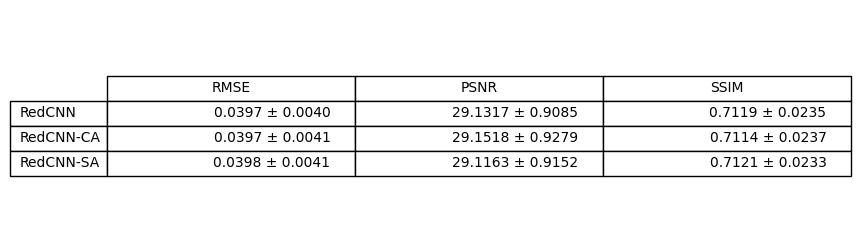

In [294]:
import numpy as np
import matplotlib.pyplot as plt

# RedCNN 결과
redcnn_rmse_mean, redcnn_rmse_sd = np.mean(redcnn_rmse_list), np.std(redcnn_rmse_list)
redcnn_psnr_mean, redcnn_psnr_sd = np.mean(redcnn_psnr_list), np.std(redcnn_psnr_list)
redcnn_ssim_mean, redcnn_ssim_sd = np.mean(redcnn_ssim_list), np.std(redcnn_ssim_list)

# RedCNN-CA 결과
redcnnCA_rmse_mean, redcnnCA_rmse_sd = np.mean(redcnnCA_rmse_list), np.std(redcnnCA_rmse_list)
redcnnCA_psnr_mean, redcnnCA_psnr_sd = np.mean(redcnnCA_psnr_list), np.std(redcnnCA_psnr_list)
redcnnCA_ssim_mean, redcnnCA_ssim_sd = np.mean(redcnnCA_ssim_list), np.std(redcnnCA_ssim_list)

# RedCNN-SA 결과
redcnnSA_rmse_mean, redcnnSA_rmse_sd = np.mean(redcnnSA_rmse_list), np.std(redcnnSA_rmse_list)
redcnnSA_psnr_mean, redcnnSA_psnr_sd = np.mean(redcnnSA_psnr_list), np.std(redcnnSA_psnr_list)
redcnnSA_ssim_mean, redcnnSA_ssim_sd = np.mean(redcnnSA_ssim_list), np.std(redcnnSA_ssim_list)

# 결과를 mean ± sd 형식으로 표현
redcnn_results = [
    f"{redcnn_rmse_mean:.4f} ± {redcnn_rmse_sd:.4f}",
    f"{redcnn_psnr_mean:.4f} ± {redcnn_psnr_sd:.4f}",
    f"{redcnn_ssim_mean:.4f} ± {redcnn_ssim_sd:.4f}"
]

redcnnCA_results = [
    f"{redcnnCA_rmse_mean:.4f} ± {redcnnCA_rmse_sd:.4f}",
    f"{redcnnCA_psnr_mean:.4f} ± {redcnnCA_psnr_sd:.4f}",
    f"{redcnnCA_ssim_mean:.4f} ± {redcnnCA_ssim_sd:.4f}"
]

redcnnSA_results = [
    f"{redcnnSA_rmse_mean:.4f} ± {redcnnSA_rmse_sd:.4f}",
    f"{redcnnSA_psnr_mean:.4f} ± {redcnnSA_psnr_sd:.4f}",
    f"{redcnnSA_ssim_mean:.4f} ± {redcnnSA_ssim_sd:.4f}"
]

# 테이블 데이터
rows = ["RedCNN", "RedCNN-CA", "RedCNN-SA"]
columns = ["RMSE", "PSNR", "SSIM"]
table_data = [redcnn_results, redcnnCA_results, redcnnSA_results]

# 테이블 생성
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')  # 축 숨기기
ax.axis('tight')  # 테이블 맞춤 조정
table = ax.table(cellText=table_data, rowLabels=rows, colLabels=columns, loc='center')

# 스타일 설정
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)  # 테이블 크기 조정

plt.show()


## unet 안에서 비교

In [295]:
# U-Net 결과
output_dir = "/root/code/unet/base/"
unet_rmse_list = np.load(output_dir + file_names["loss"])
unet_psnr_list = np.load(output_dir + file_names["psnr"])
unet_ssim_list = np.load(output_dir + file_names["ssim"])

# U-Net-CA 결과
output_dir = "/root/code/unet/attention_channel/"
unetCA_rmse_list = np.load(output_dir + file_names["loss"])
unetCA_psnr_list = np.load(output_dir + file_names["psnr"])
unetCA_ssim_list = np.load(output_dir + file_names["ssim"])

# U-Net-SA 결과
output_dir = "/root/code/unet/attention_spatial/"
unetSA_rmse_list = np.load(output_dir + file_names["loss"])
unetSA_psnr_list = np.load(output_dir + file_names["psnr"])
unetSA_ssim_list = np.load(output_dir + file_names["ssim"])

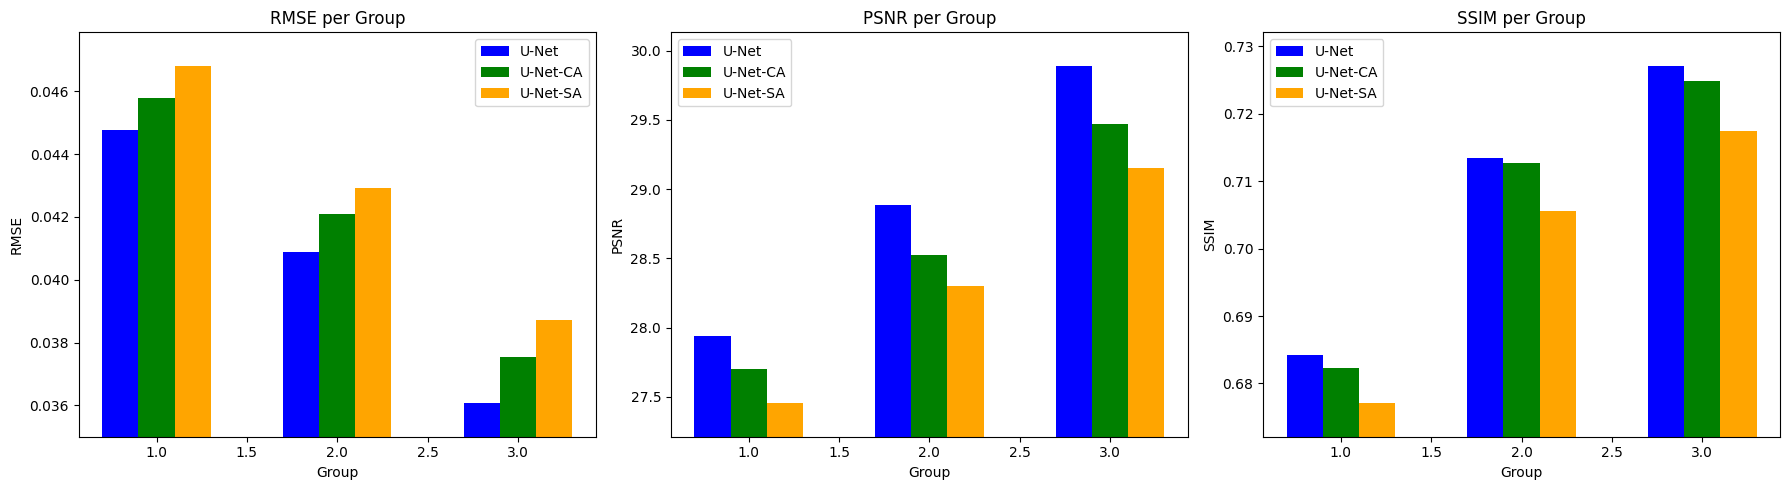

In [296]:
# 결과 그룹화
unet_rmse_groups = [np.mean(unet_rmse_list[0:2]), np.mean(unet_rmse_list[2:4]), np.mean(unet_rmse_list[4:6])]
unet_psnr_groups = [np.mean(unet_psnr_list[0:2]), np.mean(unet_psnr_list[2:4]), np.mean(unet_psnr_list[4:6])]
unet_ssim_groups = [np.mean(unet_ssim_list[0:2]), np.mean(unet_ssim_list[2:4]), np.mean(unet_ssim_list[4:6])]

unetCA_rmse_groups = [np.mean(unetCA_rmse_list[0:2]), np.mean(unetCA_rmse_list[2:4]), np.mean(unetCA_rmse_list[4:6])]
unetCA_psnr_groups = [np.mean(unetCA_psnr_list[0:2]), np.mean(unetCA_psnr_list[2:4]), np.mean(unetCA_psnr_list[4:6])]
unetCA_ssim_groups = [np.mean(unetCA_ssim_list[0:2]), np.mean(unetCA_ssim_list[2:4]), np.mean(unetCA_ssim_list[4:6])]

unetSA_rmse_groups = [np.mean(unetSA_rmse_list[0:2]), np.mean(unetSA_rmse_list[2:4]), np.mean(unetSA_rmse_list[4:6])]
unetSA_psnr_groups = [np.mean(unetSA_psnr_list[0:2]), np.mean(unetSA_psnr_list[2:4]), np.mean(unetSA_psnr_list[4:6])]
unetSA_ssim_groups = [np.mean(unetSA_ssim_list[0:2]), np.mean(unetSA_ssim_list[2:4]), np.mean(unetSA_ssim_list[4:6])]

# 그룹 인덱스 (1, 2, 3)
groups = np.array([1, 2, 3])
bar_width = 0.2  # 막대 너비
offset = bar_width

# y축 범위 설정
def get_y_limits(data_groups):
    all_values = np.concatenate(data_groups)
    min_val = np.min(all_values)
    max_val = np.max(all_values)
    margin = (max_val - min_val) * 0.1  # 여백 추가
    return min_val - margin, max_val + margin

rmse_ymin, rmse_ymax = get_y_limits([unet_rmse_groups, unetCA_rmse_groups, unetSA_rmse_groups])
psnr_ymin, psnr_ymax = get_y_limits([unet_psnr_groups, unetCA_psnr_groups, unetSA_psnr_groups])
ssim_ymin, ssim_ymax = get_y_limits([unet_ssim_groups, unetCA_ssim_groups, unetSA_ssim_groups])

# 그래프 그리기
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# RMSE 그래프
axs[0].bar(groups - offset, unet_rmse_groups, bar_width, label='U-Net', color='b')
axs[0].bar(groups, unetCA_rmse_groups, bar_width, label='U-Net-CA', color='g')
axs[0].bar(groups + offset, unetSA_rmse_groups, bar_width, label='U-Net-SA', color='orange')
axs[0].set_title('RMSE per Group')
axs[0].set_xlabel('Group')
axs[0].set_ylabel('RMSE')
axs[0].set_ylim(rmse_ymin, rmse_ymax)  # y축 범위 설정
axs[0].legend()

# PSNR 그래프
axs[1].bar(groups - offset, unet_psnr_groups, bar_width, label='U-Net', color='b')
axs[1].bar(groups, unetCA_psnr_groups, bar_width, label='U-Net-CA', color='g')
axs[1].bar(groups + offset, unetSA_psnr_groups, bar_width, label='U-Net-SA', color='orange')
axs[1].set_title('PSNR per Group')
axs[1].set_xlabel('Group')
axs[1].set_ylabel('PSNR')
axs[1].set_ylim(psnr_ymin, psnr_ymax)  # y축 범위 설정
axs[1].legend()

# SSIM 그래프
axs[2].bar(groups - offset, unet_ssim_groups, bar_width, label='U-Net', color='b')
axs[2].bar(groups, unetCA_ssim_groups, bar_width, label='U-Net-CA', color='g')
axs[2].bar(groups + offset, unetSA_ssim_groups, bar_width, label='U-Net-SA', color='orange')
axs[2].set_title('SSIM per Group')
axs[2].set_xlabel('Group')
axs[2].set_ylabel('SSIM')
axs[2].set_ylim(ssim_ymin, ssim_ymax)  # y축 범위 설정
axs[2].legend()

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

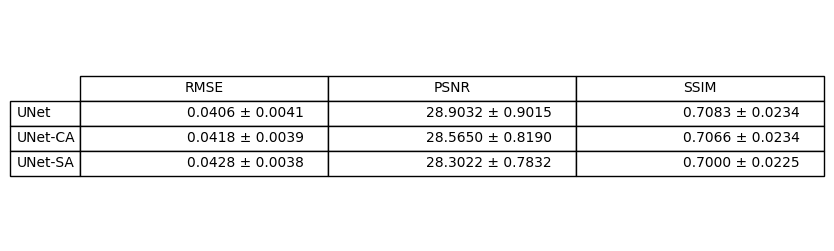

In [297]:
import numpy as np
import matplotlib.pyplot as plt

# UNet 결과
unet_rmse_mean, unet_rmse_sd = np.mean(unet_rmse_list), np.std(unet_rmse_list)
unet_psnr_mean, unet_psnr_sd = np.mean(unet_psnr_list), np.std(unet_psnr_list)
unet_ssim_mean, unet_ssim_sd = np.mean(unet_ssim_list), np.std(unet_ssim_list)

# UNet-CA 결과
unetCA_rmse_mean, unetCA_rmse_sd = np.mean(unetCA_rmse_list), np.std(unetCA_rmse_list)
unetCA_psnr_mean, unetCA_psnr_sd = np.mean(unetCA_psnr_list), np.std(unetCA_psnr_list)
unetCA_ssim_mean, unetCA_ssim_sd = np.mean(unetCA_ssim_list), np.std(unetCA_ssim_list)

# UNet-SA 결과
unetSA_rmse_mean, unetSA_rmse_sd = np.mean(unetSA_rmse_list), np.std(unetSA_rmse_list)
unetSA_psnr_mean, unetSA_psnr_sd = np.mean(unetSA_psnr_list), np.std(unetSA_psnr_list)
unetSA_ssim_mean, unetSA_ssim_sd = np.mean(unetSA_ssim_list), np.std(unetSA_ssim_list)

# 결과를 mean ± sd 형식으로 표현
unet_results = [
    f"{unet_rmse_mean:.4f} ± {unet_rmse_sd:.4f}",
    f"{unet_psnr_mean:.4f} ± {unet_psnr_sd:.4f}",
    f"{unet_ssim_mean:.4f} ± {unet_ssim_sd:.4f}"
]

unetCA_results = [
    f"{unetCA_rmse_mean:.4f} ± {unetCA_rmse_sd:.4f}",
    f"{unetCA_psnr_mean:.4f} ± {unetCA_psnr_sd:.4f}",
    f"{unetCA_ssim_mean:.4f} ± {unetCA_ssim_sd:.4f}"
]

unetSA_results = [
    f"{unetSA_rmse_mean:.4f} ± {unetSA_rmse_sd:.4f}",
    f"{unetSA_psnr_mean:.4f} ± {unetSA_psnr_sd:.4f}",
    f"{unetSA_ssim_mean:.4f} ± {unetSA_ssim_sd:.4f}"
]

# 테이블 데이터
rows = ["UNet", "UNet-CA", "UNet-SA"]
columns = ["RMSE", "PSNR", "SSIM"]
table_data = [unet_results, unetCA_results, unetSA_results]

# 테이블 생성
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')  # 축 숨기기
ax.axis('tight')  # 테이블 맞춤 조정
table = ax.table(cellText=table_data, rowLabels=rows, colLabels=columns, loc='center')

# 스타일 설정
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)  # 테이블 크기 조정

plt.show()


## 전체 비교

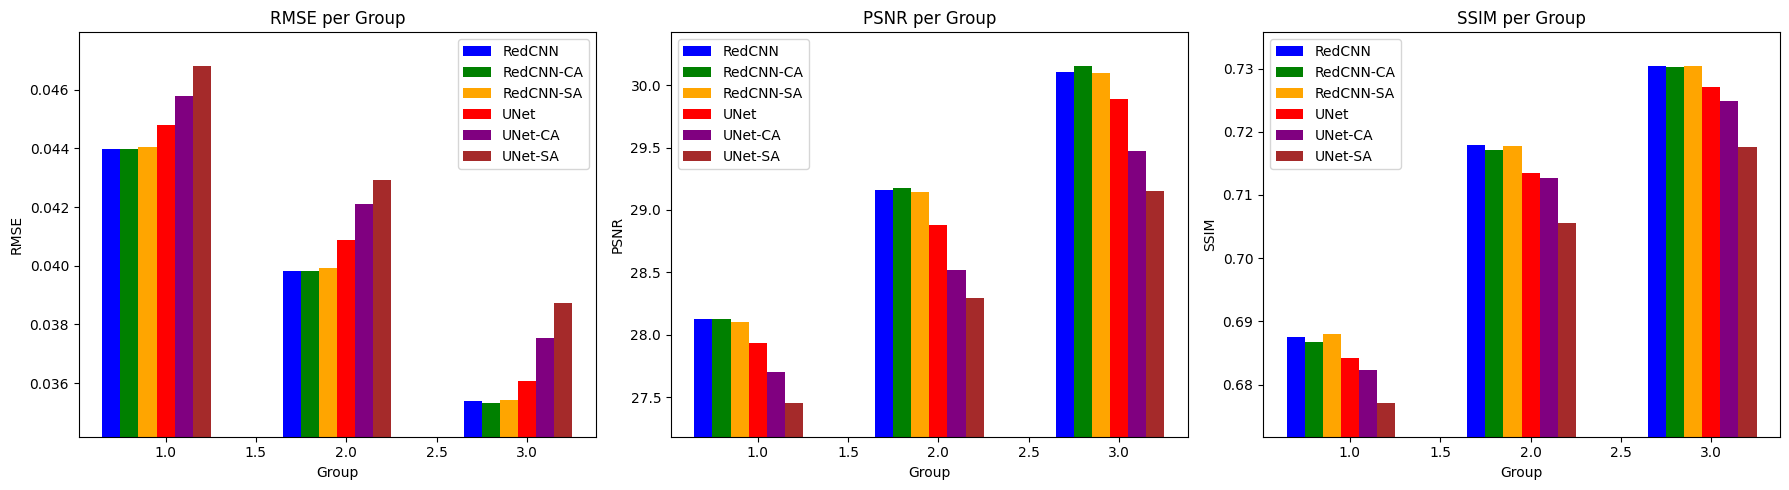

In [298]:
import numpy as np
import matplotlib.pyplot as plt

# y축 범위 설정 함수
def get_y_limits(data_groups):
    all_values = np.concatenate(data_groups)
    min_val = np.min(all_values)
    max_val = np.max(all_values)
    margin = (max_val - min_val) * 0.1  # 10% 여유
    return min_val - margin, max_val + margin

# RMSE, PSNR, SSIM의 y축 범위 계산
rmse_ymin, rmse_ymax = get_y_limits([redcnn_rmse_groups, redcnnCA_rmse_groups, redcnnSA_rmse_groups, 
                                     unet_rmse_groups, unetCA_rmse_groups, unetSA_rmse_groups])
psnr_ymin, psnr_ymax = get_y_limits([redcnn_psnr_groups, redcnnCA_psnr_groups, redcnnSA_psnr_groups, 
                                     unet_psnr_groups, unetCA_psnr_groups, unetSA_psnr_groups])
ssim_ymin, ssim_ymax = get_y_limits([redcnn_ssim_groups, redcnnCA_ssim_groups, redcnnSA_ssim_groups, 
                                     unet_ssim_groups, unetCA_ssim_groups, unetSA_ssim_groups])

# 그룹 인덱스 (1, 2, 3)
groups = np.array([1, 2, 3])
bar_width = 0.1  # 막대 너비
offset = bar_width

# 그래프 그리기
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# RMSE 그래프
axs[0].bar(groups - 3 * offset, redcnn_rmse_groups, bar_width, label='RedCNN', color='b')
axs[0].bar(groups - 2 * offset, redcnnCA_rmse_groups, bar_width, label='RedCNN-CA', color='g')
axs[0].bar(groups - offset, redcnnSA_rmse_groups, bar_width, label='RedCNN-SA', color='orange')
axs[0].bar(groups, unet_rmse_groups, bar_width, label='UNet', color='r')
axs[0].bar(groups + offset, unetCA_rmse_groups, bar_width, label='UNet-CA', color='purple')
axs[0].bar(groups + 2 * offset, unetSA_rmse_groups, bar_width, label='UNet-SA', color='brown')
axs[0].set_title('RMSE per Group')
axs[0].set_xlabel('Group')
axs[0].set_ylabel('RMSE')
axs[0].set_ylim(rmse_ymin, rmse_ymax)  # y축 범위 설정
axs[0].legend()

# PSNR 그래프
axs[1].bar(groups - 3 * offset, redcnn_psnr_groups, bar_width, label='RedCNN', color='b')
axs[1].bar(groups - 2 * offset, redcnnCA_psnr_groups, bar_width, label='RedCNN-CA', color='g')
axs[1].bar(groups - offset, redcnnSA_psnr_groups, bar_width, label='RedCNN-SA', color='orange')
axs[1].bar(groups, unet_psnr_groups, bar_width, label='UNet', color='r')
axs[1].bar(groups + offset, unetCA_psnr_groups, bar_width, label='UNet-CA', color='purple')
axs[1].bar(groups + 2 * offset, unetSA_psnr_groups, bar_width, label='UNet-SA', color='brown')
axs[1].set_title('PSNR per Group')
axs[1].set_xlabel('Group')
axs[1].set_ylabel('PSNR')
axs[1].set_ylim(psnr_ymin, psnr_ymax)  # y축 범위 설정
axs[1].legend()

# SSIM 그래프
axs[2].bar(groups - 3 * offset, redcnn_ssim_groups, bar_width, label='RedCNN', color='b')
axs[2].bar(groups - 2 * offset, redcnnCA_ssim_groups, bar_width, label='RedCNN-CA', color='g')
axs[2].bar(groups - offset, redcnnSA_ssim_groups, bar_width, label='RedCNN-SA', color='orange')
axs[2].bar(groups, unet_ssim_groups, bar_width, label='UNet', color='r')
axs[2].bar(groups + offset, unetCA_ssim_groups, bar_width, label='UNet-CA', color='purple')
axs[2].bar(groups + 2 * offset, unetSA_ssim_groups, bar_width, label='UNet-SA', color='brown')
axs[2].set_title('SSIM per Group')
axs[2].set_xlabel('Group')
axs[2].set_ylabel('SSIM')
axs[2].set_ylim(ssim_ymin, ssim_ymax)  # y축 범위 설정
axs[2].legend()

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

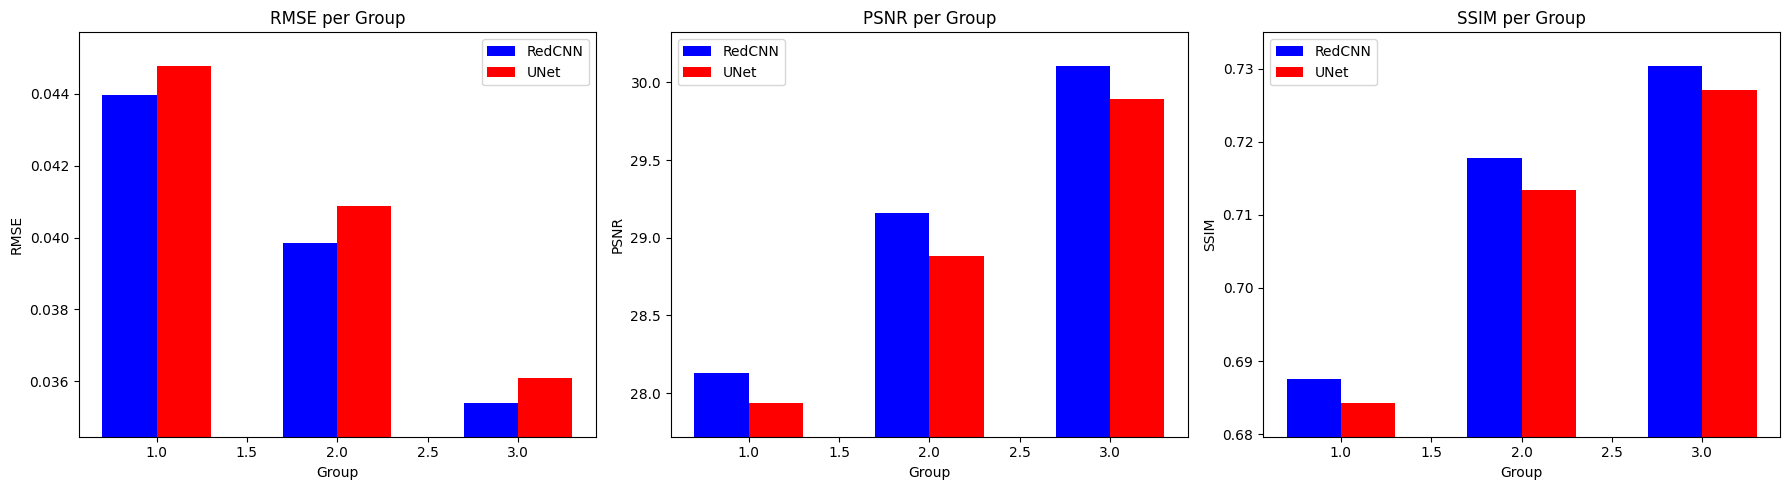

In [299]:
import numpy as np
import matplotlib.pyplot as plt

# y축 범위 설정 함수
def get_y_limits(data_groups):
    all_values = np.concatenate(data_groups)
    min_val = np.min(all_values)
    max_val = np.max(all_values)
    margin = (max_val - min_val) * 0.1  # 10% 여유
    return min_val - margin, max_val + margin

# RMSE, PSNR, SSIM의 y축 범위 계산
rmse_ymin, rmse_ymax = get_y_limits([redcnn_rmse_groups, unet_rmse_groups])
psnr_ymin, psnr_ymax = get_y_limits([redcnn_psnr_groups, unet_psnr_groups])
ssim_ymin, ssim_ymax = get_y_limits([redcnn_ssim_groups, unet_ssim_groups])

# 그룹 인덱스 (1, 2, 3)
groups = np.array([1, 2, 3])
bar_width = 0.3  # 막대 너비
offset = bar_width / 2

# 그래프 그리기
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# RMSE 그래프
axs[0].bar(groups - offset, redcnn_rmse_groups, bar_width, label='RedCNN', color='b')
axs[0].bar(groups + offset, unet_rmse_groups, bar_width, label='UNet', color='r')
axs[0].set_title('RMSE per Group')
axs[0].set_xlabel('Group')
axs[0].set_ylabel('RMSE')
axs[0].set_ylim(rmse_ymin, rmse_ymax)  # y축 범위 설정
axs[0].legend()

# PSNR 그래프
axs[1].bar(groups - offset, redcnn_psnr_groups, bar_width, label='RedCNN', color='b')
axs[1].bar(groups + offset, unet_psnr_groups, bar_width, label='UNet', color='r')
axs[1].set_title('PSNR per Group')
axs[1].set_xlabel('Group')
axs[1].set_ylabel('PSNR')
axs[1].set_ylim(psnr_ymin, psnr_ymax)  # y축 범위 설정
axs[1].legend()

# SSIM 그래프
axs[2].bar(groups - offset, redcnn_ssim_groups, bar_width, label='RedCNN', color='b')
axs[2].bar(groups + offset, unet_ssim_groups, bar_width, label='UNet', color='r')
axs[2].set_title('SSIM per Group')
axs[2].set_xlabel('Group')
axs[2].set_ylabel('SSIM')
axs[2].set_ylim(ssim_ymin, ssim_ymax)  # y축 범위 설정
axs[2].legend()

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()